In [1]:
# Colab setup

# from google.colab import drive
# drive.mount("/content/drive/")

# %cd "/content/drive/MyDrive/PACS/APSC_project/bayesian_network/examples/1_darcy_flow"

# try:
#     from dlroms import *
# except:
#     !pip install git+https://github.com/NicolaRFranco/dlroms.git
#     from dlroms import *

In [1]:
from dlroms import *
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from IPython.display import clear_output as clc

In [2]:
# Domain and mesh definition

domain = fe.rectangle((0.0, 0.0), (1.0, 1.0)) # - fe.rectangle((0.3, 0.3), (0.7, 0.7))
mesh = fe.mesh(domain, stepsize=0.05)
mesh_coarse = fe.mesh(domain, stepsize=0.1)
clc()

In [3]:
# Load train and test data

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

path_train = os.path.join(os.getcwd(), "snapshots", "snapshots_train.npz")
data_train = np.load(path_train)

N_train = data_train['K'].shape[0]
K_train = torch.tensor(data_train['K'].astype(np.float32)).to(device)
p_train = torch.tensor(data_train['p'].astype(np.float32)).to(device)
u_x_train = torch.tensor(data_train['u_x'].astype(np.float32)).to(device)
u_y_train = torch.tensor(data_train['u_y'].astype(np.float32)).to(device)

path_test = os.path.join(os.getcwd(), "snapshots", "snapshots_test.npz")
data_test = np.load(path_test)

N_test = data_test['K'].shape[0]
K_test = torch.tensor(data_test['K'].astype(np.float32)).to(device)
p_test = torch.tensor(data_test['p'].astype(np.float32)).to(device)
u_x_test = torch.tensor(data_test['u_x'].astype(np.float32)).to(device)
u_y_test = torch.tensor(data_test['u_y'].astype(np.float32)).to(device)

## Deterministic network

In [5]:
# Train mesh-informed network for pressure

V = fe.space(mesh, 'CG', 1)

layer_1 = Local(V, V, support=0.25)
layer_2 = Local(V, V, support=0.25)
layer_3 = Local(V, V, support=0.25, activation=None)

p_model = DFNN(layer_1, layer_2, layer_3)
p_model.He()

print("Trainable parameters:", p_model.dof())

if torch.cuda.is_available():
	p_model.cuda()

Trainable parameters: 80802


In [6]:
p_model.train(K_train, p_train, ntrain=N_train, nvalid=int(0.2*N_train), epochs=100, loss=mse(euclidean), verbose=True)

		Train		Valid		Test
Epoch 31:	3.01e-02	4.88e-02	nan.

>> ETA: 3m 38.69s.

Training complete. Elapsed time: 1 minutes 36.17 seconds.


In [63]:
# Train encoder-decoder network for pressure (1)

from dlroms import *
from dlroms.dnns import *

V = fe.space(mesh, 'CG', 1) # 441 dofs
Nh = V.dim()

m = 16

# window, channels = (1,1), stride = 1, padding = 0

# # Encoder
# psi = Reshape(1, 21, 21) + \
#       Conv2D(3, (1, m), stride=2, padding=1) + \
#       Conv2D(3, (m, 2 * m), stride=2, padding=1)

# # Decoder
# psi_prime = Deconv2D(3, (2 * m, m), stride=2, padding=1) + \
#             Deconv2D(3, (m, 1), stride=2, padding=1, activation=None) + \
#             Reshape(-1)

# Encoder
psi = Reshape(1, 21, 21) + \
      Conv2D(3, (1, m), stride=2) + \
      Conv2D(3, (m, 2 * m), stride=2)

# Decoder
psi_prime = Deconv2D(4, (2 * m, m), stride=2) + \
            Deconv2D(3, (m, 1), stride=2, activation=None) + \
            Reshape(-1)

p_model = DFNN(psi, psi_prime)
p_model.He()

print("Trainable parameters:", p_model.dof())

if torch.cuda.is_available():
	p_model.cuda()

Trainable parameters: 13153


In [64]:
p_model.train(K_train, p_train, ntrain=N_train, nvalid=int(0.2*N_train), epochs=200, loss=mse(euclidean), verbose=True)

		Train		Valid		Test
Epoch 118:	1.54e-01	1.76e-01	nan.

>> ETA: 5m 56.41s.

Training complete. Elapsed time: 8 minutes 26.07 seconds.


In [109]:
# Train encoder-decoder network for pressure (2)

from dlroms import *
from dlroms.dnns import *

V = fe.space(mesh, 'CG', 1) # 441 dofs
Nh = V.dim()

m = 16

# window, channels = (1,1), stride = 1, padding = 0

# # Encoder
# psi = Reshape(1, 21, 21) + \
#       Conv2D(3, (1, m), stride=2, padding=1) + \
#       Conv2D(3, (m, 2 * m), stride=2, padding=1) + \
#       Conv2D(3, (2 * m, 4 * m), stride=2, padding=1)

# # Decoder
# psi_prime = Deconv2D(3, (4 * m, 2 * m), stride=2, padding=1) + \
#             Deconv2D(3, (2 * m, m), stride=2) + \
#             Deconv2D(3, (m, 1), stride=2, padding=1, activation=None) + \
#             Reshape(-1)

# Encoder
psi = Reshape(1, 21, 21) + \
      Conv2D(6, (1, m), stride=1) + \
      Conv2D(7, (m, 2 * m), stride=1) + \
      Conv2D(7, (2 * m, 4 * m), stride=1)

# Decoder
psi_prime = Deconv2D(7, (4 * m, 2 * m), stride=1) + \
            Deconv2D(7, (2 * m, m), stride=1) + \
            Deconv2D(6, (m, 1), stride=1, activation=None) + \
            Reshape(-1)

p_model = DFNN(psi, psi_prime)
p_model.He()

print("Trainable parameters:", p_model.dof())

if torch.cuda.is_available():
	p_model.cuda()

Trainable parameters: 252193


In [ ]:
p_model.train(K_train, p_train, ntrain=N_train, nvalid=int(0.2*N_train), epochs=200, loss=mse(euclidean), verbose=True)

In [76]:
# Train mesh-informed encoder-decoder network for pressure (1)

from dlroms import *
from dlroms.dnns import *

V = fe.space(mesh, 'CG', 1) # 441 dofs
V_coarse = fe.space(mesh_coarse, 'CG', 1) # 121 dofs
Nh = V.dim()

m = 16

# window, channels = (1,1), stride = 1, padding = 0

chi = Local(V, V_coarse, support=0.2)

# # Encoder
# psi = Reshape(1, 11, 11) + \
#       Conv2D(3, (1, m), stride=2, padding=1) + \
#       Conv2D(3, (m, 2 * m), stride=2, padding=1)

# # Decoder
# psi_prime = Deconv2D(4, (2 * m, m), stride=2, padding=1) + \
#             Deconv2D(3, (m, 1), stride=2, padding=1, activation=None) + \
#             Reshape(-1)

# Encoder
psi = Reshape(1, 11, 11) + \
      Conv2D(3, (1, m), stride=2) + \
      Conv2D(3, (m, 2 * m), stride=2)

# Decoder
psi_prime = Deconv2D(3, (2 * m, m), stride=2) + \
            Deconv2D(3, (m, 1), stride=2, activation=None) + \
            Reshape(-1)

chi_prime = Local(V_coarse, V, support=0.2)

p_model = DFNN(chi, psi, psi_prime, chi_prime)
p_model.He()

print("Trainable parameters:", p_model.dof())

if torch.cuda.is_available():
	p_model.cuda()

Trainable parameters: 19445


In [77]:
p_model.train(K_train, p_train, ntrain=N_train, nvalid=int(0.2*N_train), epochs=200, loss=mse(euclidean), verbose=True)

		Train		Valid		Test
Epoch 165:	2.80e-02	3.86e-02	nan.

>> ETA: 1m 10.37s.

Training complete. Elapsed time: 5 minutes 22.48 seconds.


In [38]:
# Compare mesh-informed with dense encoder-decoder network for pressure (1)

from dlroms import *
from dlroms.dnns import *

V = fe.space(mesh, 'CG', 1) # 441 dofs
V_coarse = fe.space(mesh_coarse, 'CG', 1) # 121 dofs
Nh = V.dim()

m = 16

# window, channels = (1,1), stride = 1, padding = 0

chi = Dense(V, V_coarse)

# Encoder
psi = Reshape(1, 11, 11) + \
      Conv2D(3, (1, m), stride=2, padding=1) + \
      Conv2D(3, (m, 2 * m), stride=2, padding=1)

# Decoder
psi_prime = Deconv2D(4, (2 * m, m), stride=2, padding=1) + \
            Deconv2D(3, (m, 1), stride=2, padding=1, activation=None) + \
            Reshape(-1)

chi_prime = Dense(V_coarse, V)

p_model = DFNN(chi, psi, psi_prime, chi_prime)
p_model.He()

print("Trainable parameters:", p_model.dof())

if torch.cuda.is_available():
	p_model.cuda()

Trainable parameters: 120437


In [39]:
p_model.train(K_train, p_train, ntrain=N_train, nvalid=int(0.2*N_train), epochs=200, loss=mse(euclidean), verbose=True)

		Train		Valid		Test
Epoch 100:	3.17e-02	5.79e-02	nan.

>> ETA: 4m 25.97s.

Training complete. Elapsed time: 4 minutes 23.04 seconds.


In [124]:
# Train mesh-informed encoder-decoder network for pressure (2)

from dlroms import *
from dlroms.dnns import *

V = fe.space(mesh, 'CG', 1) # 441 dofs
V_coarse = fe.space(mesh_coarse, 'CG', 1) # 121 dofs
Nh = V.dim()

m = 16

# window, channels = (1,1), stride = 1, padding = 0

chi = Local(V, V_coarse, support=0.2)

# # Encoder
# psi = Reshape(1, 11, 11) + \
#       Conv2D(3, (1, m), stride=2, padding=1) + \
#       Conv2D(3, (m, 2 * m), stride=2, padding=1) + \
#       Conv2D(3, (2 * m, 4 * m), stride=2, padding=1)

# # Decoder
# psi_prime = Deconv2D(3, (4 * m, 2 * m), stride=2, padding=1) + \
#             Deconv2D(4, (2 * m, m), stride=3, padding=2) + \
#             Deconv2D(3, (m, 1), stride=2, padding=1, activation=None) + \
#             Reshape(-1)

# Encoder
psi = Reshape(1, 11, 11) + \
      Conv2D(3, (1, m), stride=1) + \
      Conv2D(4, (m, 2 * m), stride=1) + \
      Conv2D(4, (2 * m, 4 * m), stride=1)

# Decoder
psi_prime = Deconv2D(4, (4 * m, 2 * m), stride=1) + \
            Deconv2D(4, (2 * m, m), stride=1) + \
            Deconv2D(3, (m, 1), stride=1, activation=None) + \
            Reshape(-1)

chi_prime = Local(V_coarse, V, support=0.2)

p_model = DFNN(chi, psi, psi_prime, chi_prime)
p_model.He()

if torch.cuda.is_available():
	p_model.cuda()

print("Trainable parameters:", p_model.dof())

Trainable parameters: 92245


In [ ]:
p_model.train(K_train, p_train, ntrain=N_train, nvalid=int(0.2*N_train), epochs=200, loss=mse(euclidean), verbose=True)

In [ ]:
# 900 training snapshots (20% validation) [train/test mse: 3e-2]
# Relative training error: 7.73%
# Relative test error: 9.65%

# 1800 training snapshots (20% validation) [train/test mse: 2e-2]
# Relative training error: 6.66%
# Relative test error: 7.91%

In [125]:
# Compare mesh-informed with dense encoder-decoder network for pressure (2)

from dlroms import *
from dlroms.dnns import *

V = fe.space(mesh, 'CG', 1) # 441 dofs
V_coarse = fe.space(mesh_coarse, 'CG', 1) # 121 dofs
Nh = V.dim()

m = 16

# window, channels = (1,1), stride = 1, padding = 0

chi = Dense(V, V_coarse)

# # Encoder
# psi = Reshape(1, 11, 11) + \
#       Conv2D(3, (1, m), stride=2, padding=1) + \
#       Conv2D(3, (m, 2 * m), stride=2, padding=1) + \
#       Conv2D(3, (2 * m, 4 * m), stride=2, padding=1)

# # Decoder
# psi_prime = Deconv2D(3, (4 * m, 2 * m), stride=2, padding=1) + \
#             Deconv2D(4, (2 * m, m), stride=3, padding=2) + \
#             Deconv2D(3, (m, 1), stride=2, padding=1, activation=None) + \
#             Reshape(-1)

# Encoder
psi = Reshape(1, 11, 11) + \
      Conv2D(3, (1, m), stride=1) + \
      Conv2D(4, (m, 2 * m), stride=1) + \
      Conv2D(4, (2 * m, 4 * m), stride=1)

# Decoder
psi_prime = Deconv2D(4, (4 * m, 2 * m), stride=1) + \
            Deconv2D(4, (2 * m, m), stride=1) + \
            Deconv2D(3, (m, 1), stride=1, activation=None) + \
            Reshape(-1)

chi_prime = Dense(V_coarse, V)

p_model = DFNN(chi, psi, psi_prime, chi_prime)
p_model.He()

if torch.cuda.is_available():
	p_model.cuda()

print("Trainable parameters:", p_model.dof())

Trainable parameters: 189653


In [ ]:
p_model.train(K_train, p_train, ntrain=N_train, nvalid=int(0.2*N_train), epochs=200, loss=mse(euclidean), verbose=True)

In [78]:
# Generate predictions

p_model.eval()

with torch.no_grad():
  p_pred_train = p_model(K_train)
  p_pred = p_model(K_test)

In [79]:
# Compute relative error

error_train = torch.norm(p_train - p_pred_train, dim=1) / torch.norm(p_train, dim=1)
error_test = torch.norm(p_test - p_pred, dim=1) / torch.norm(p_test, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative training error: 9.98%
Relative test error: 11.28%


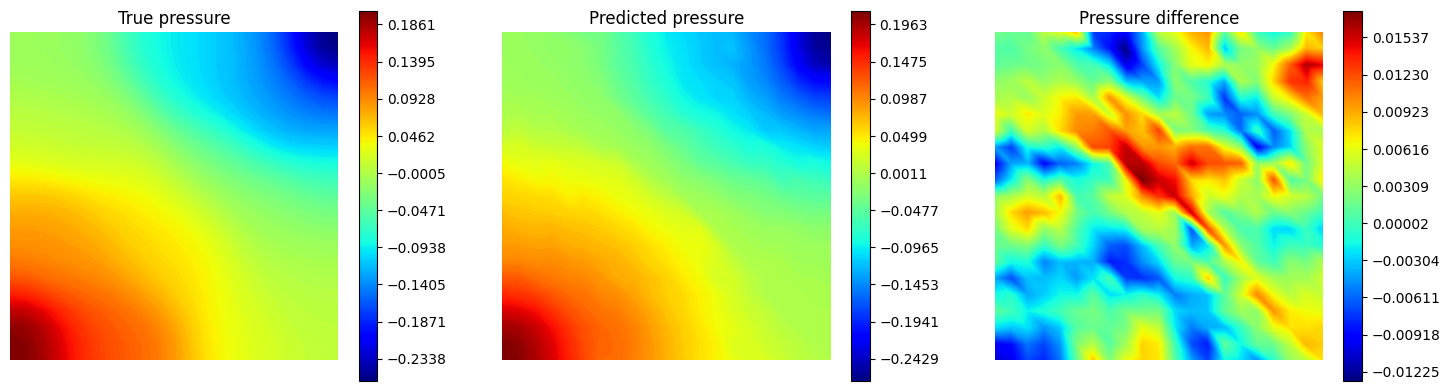

In [80]:
idx = 50

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(p_test[idx], V, cmap='jet', colorbar=True)
plt.title("True pressure")

plt.subplot(1, 3, 2)
fe.plot(p_pred[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted pressure")

plt.subplot(1, 3, 3)
fe.plot(p_test[idx] - p_pred[idx], V, cmap='jet', colorbar=True)
plt.title("Pressure difference")

plt.show()

In [32]:
# Examine weights in mesh-informed layers

W1 = p_model[0].W() # weight matrix of the 1st layer
print(W1)
print(p_model[0].loc) # mask
print(p_model[0].weight) # should be the same as W1
with torch.no_grad(): # needed to apply in-place operation to leaf variables # TODO: does it break the computational graph?
	p_model[0].weight[0] = 0.0 # set the first weight to zero
print(p_model[0].weight)

tensor([[ 0.3068, -0.3416,  0.1072,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2675, -0.1602,  0.1781,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1725,  0.1140, -0.0236,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.6298, -0.2131, -0.3007],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0428,  0.3569,  0.1772],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.2421,  0.3554, -0.3466]],
       grad_fn=<IndexPutBackward0>)
(array([  0,   0,   0, ..., 440, 440, 440]), array([  0,   1,   2, ..., 438, 439, 440]))
Parameter containing:
tensor([ 0.3068, -0.3416,  0.1072,  ..., -0.2421,  0.3554, -0.3466],
       requires_grad=True)
Parameter containing:
tensor([ 0.0000, -0.3416,  0.1072,  ..., -0.2421,  0.3554, -0.3466],
       requires_grad=True)


**NOTE**: $u$ can be actually computed analytically from $p$!

In [18]:
# Train network for velocity

V = fe.space(mesh, 'CG', 1)

layer_1 = Local(V, V, support=0.25)
layer_2 = Local(V, V, support=0.25)
layer_3 = Local(V, V, support=0.25, activation=None)

v_model = DFNN(layer_1, layer_2, layer_3)
v_model.He()

if torch.cuda.is_available():
  v_model.cuda()

v_model.train(K_train, u_x_train, ntrain=N_train, nvalid=int(0.2*N_train), epochs=100, loss=mse(euclidean), verbose=True)

		Train		Valid		Test
Epoch 20:	2.14e-01	3.16e-01	nan.

>> ETA: 3m 15.37s.

Training complete. Elapsed time: 48.23 seconds.


In [19]:
# Generate predictions

v_model.eval()

with torch.no_grad():
  u_x_pred_train = v_model(K_train)
  u_x_pred = v_model(K_test)

In [20]:
# Compute relative error

error_train = torch.norm(u_x_train - u_x_pred_train, dim=1) / torch.norm(u_x_train, dim=1)
error_test = torch.norm(u_x_test - u_x_pred, dim=1) / torch.norm(u_x_test, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative training error: 11.55%
Relative test error: 14.51%


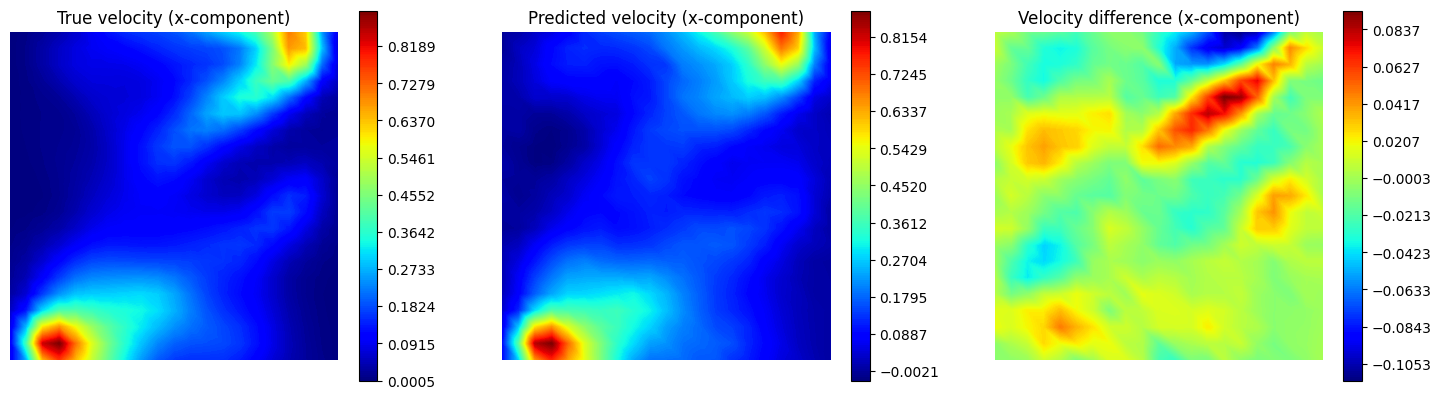

In [21]:
idx = 90

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(u_x_test[idx], V, cmap='jet', colorbar=True)
plt.title("True velocity (x-component)")

plt.subplot(1, 3, 2)
fe.plot(u_x_pred[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted velocity (x-component)")

plt.subplot(1, 3, 3)
fe.plot(u_x_test[idx] - u_x_pred[idx], V, cmap='jet', colorbar=True)
plt.title("Velocity difference (x-component)")

plt.show()

In [23]:
# Train encoder-decoder network for velocity

from dlroms import *
from dlroms.dnns import *

V = fe.space(mesh, 'CG', 1) # 441 dofs
Nh = V.dim()

m = 16

# Encoder
# window, channels = (1,1), stride = 1, padding = 0
psi = Reshape(1, 21, 21) + \
      Conv2D(3, (1, m), stride=2, padding=1) + \
      Conv2D(3, (m, 2 * m), stride=2, padding=1) + \
      Conv2D(3, (2 * m, 4 * m), stride=2, padding=1)

# Decoder
psi_prime = Deconv2D(3, (4 * m, 2 * m), stride=2, padding=1) + \
            Deconv2D(3, (2 * m, m), stride=2) + \
            Deconv2D(3, (m, 1), stride=2, padding=1, activation=None) + \
            Reshape(-1)

v_model = DFNN(psi, psi_prime)
v_model.He()

v_model.train(K_train, u_x_train, ntrain=N_train, nvalid=int(0.2*N_train), epochs=100, loss=mse(euclidean), verbose=True)

		Train		Valid		Test
Epoch 100:	1.47e-01	2.37e-01	nan.

>> ETA: 4.05s.

Training complete. Elapsed time: 6 minutes 44.78 seconds.


In [25]:
# Train mesh-informed encoder-decoder network for velocity

from dlroms import *
from dlroms.dnns import *

V = fe.space(mesh, 'CG', 1) # 441 dofs
V_coarse = fe.space(mesh_coarse, 'CG', 1) # 121 dofs
Nh = V.dim()

m = 16

# window, channels = (1,1), stride = 1, padding = 0

chi = Local(V, V_coarse, support=0.2)

# Encoder
psi = Reshape(1, 11, 11) + \
      Conv2D(3, (1, m), stride=2, padding=1) + \
      Conv2D(3, (m, 2 * m), stride=2, padding=1) + \
      Conv2D(3, (2 * m, 4 * m), stride=2, padding=1)

# Decoder
psi_prime = Deconv2D(3, (4 * m, 2 * m), stride=2, padding=1) + \
            Deconv2D(4, (2 * m, m), stride=3, padding=2) + \
            Deconv2D(3, (m, 1), stride=2, padding=1, activation=None) + \
            Reshape(-1)

chi_prime = Local(V_coarse, V, support=0.2)

v_model = DFNN(chi, psi, psi_prime, chi_prime)
v_model.He()

if torch.cuda.is_available():
	v_model.cuda()

v_model.train(K_train, u_x_train, ntrain=N_train, nvalid=int(0.2*N_train), epochs=200, loss=mse(euclidean), verbose=True)

		Train		Valid		Test
Epoch 200:	2.59e-01	3.26e-01	nan.

>> ETA: 3.73s.

Training complete. Elapsed time: 12 minutes 26.19 seconds.


## Bayesian network

In [22]:
# Bayesian network for pressure

import sys
sys.path.append(os.path.join("..", "..", "dlroms"))
from bayesian import *

V = fe.space(mesh, 'CG', 1)

layer_1 = Local(V, V, support=0.25)
layer_2 = Local(V, V, support=0.25)
layer_3 = Local(V, V, support=0.25, activation=None)

p_model = DFNN(layer_1, layer_2, layer_3)

p_bayes = Bayesian(p_model)
p_bayes.He() # set prior on weights

In [23]:
p_svgd = SVGD(p_bayes, lr=1e-2)

In [24]:
p_svgd.train(K_train, p_train, ntrain=int(0.8*N_train), loss=mse(euclidean), epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 200/200, train: 0.189678, test: 0.171469: 100%|██████████| 200/200 [09:05<00:00,  2.73s/it]


In [120]:
# p_pred_bayes = bayes(p_test)
# print(p_pred_bayes.shape) # torch.Size([20, 200, 441])

In [25]:
# Compute mean and variance of predictions

p_pred_bayes_mean_train, p_pred_bayes_var_train = p_bayes.predict(K_train)
p_pred_bayes_mean, p_pred_bayes_var = p_bayes.predict(K_test)

In [26]:
# Compute relative error

error_train = torch.norm(p_train - p_pred_bayes_mean_train, dim=1) / torch.norm(p_train, dim=1)
error_test = torch.norm(p_test - p_pred_bayes_mean, dim=1) / torch.norm(p_test, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative training error: 23.56%
Relative test error: 24.35%


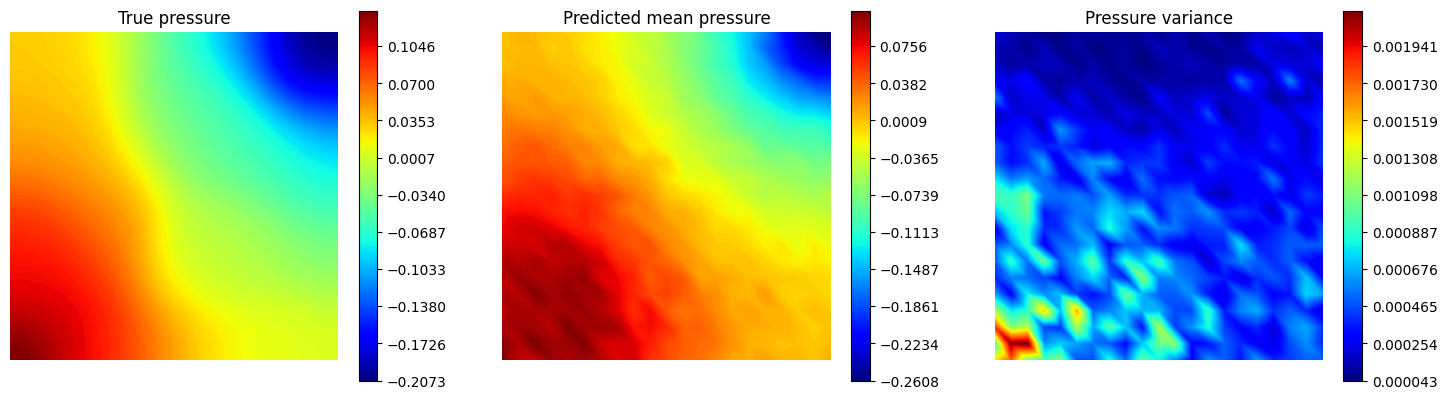

In [29]:
idx = 150

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(p_test[idx], V, cmap='jet', colorbar=True)
plt.title("True pressure")

plt.subplot(1, 3, 2)
fe.plot(p_pred_bayes_mean[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted mean pressure")

plt.subplot(1, 3, 3)
fe.plot(p_pred_bayes_var[idx], V, cmap='jet', colorbar=True)
plt.title("Pressure variance")

plt.show()

In [51]:
V = fe.space(mesh, 'CG', 1) # 441 dofs
Nh = V.dim()

m = 16

# Encoder
# window, channels = (1,1), stride = 1, padding = 0
psi = Reshape(1, 21, 21) + \
      Conv2D(3, (1, m), stride=2, padding=1) + \
      Conv2D(3, (m, 2 * m), stride=2, padding=1) + \
      Conv2D(3, (2 * m, 4 * m), stride=2, padding=1)

# Decoder
psi_prime = Deconv2D(3, (4 * m, 2 * m), stride=2, padding=1) + \
            Deconv2D(3, (2 * m, m), stride=2) + \
            Deconv2D(3, (m, 1), stride=2, padding=1, activation=None) + \
            Reshape(-1)

p_model = DFNN(psi, psi_prime)

p_bayes = Bayesian(p_model)
p_bayes.He() # set prior on weights

In [52]:
p_svgd = SVGD(p_bayes, lr=1e-2)

In [53]:
p_svgd.train(K_train, p_train, ntrain=int(0.8*N_train), loss=mse(euclidean), epochs=200)

Epoch: 200/200, train: 0.063347, test: 0.076006: 100%|██████████| 200/200 [14:14<00:00,  4.27s/it]


In [54]:
# Compute mean and variance of predictions

p_pred_bayes_mean_train, p_pred_bayes_var_train = p_bayes.predict(K_train)
p_pred_bayes_mean, p_pred_bayes_var = p_bayes.predict(K_test)

In [55]:
# Compute relative error

error_train = torch.norm(p_train - p_pred_bayes_mean_train, dim=1) / torch.norm(p_train, dim=1)
error_test = torch.norm(p_test - p_pred_bayes_mean, dim=1) / torch.norm(p_test, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative training error: 14.80%
Relative test error: 15.28%


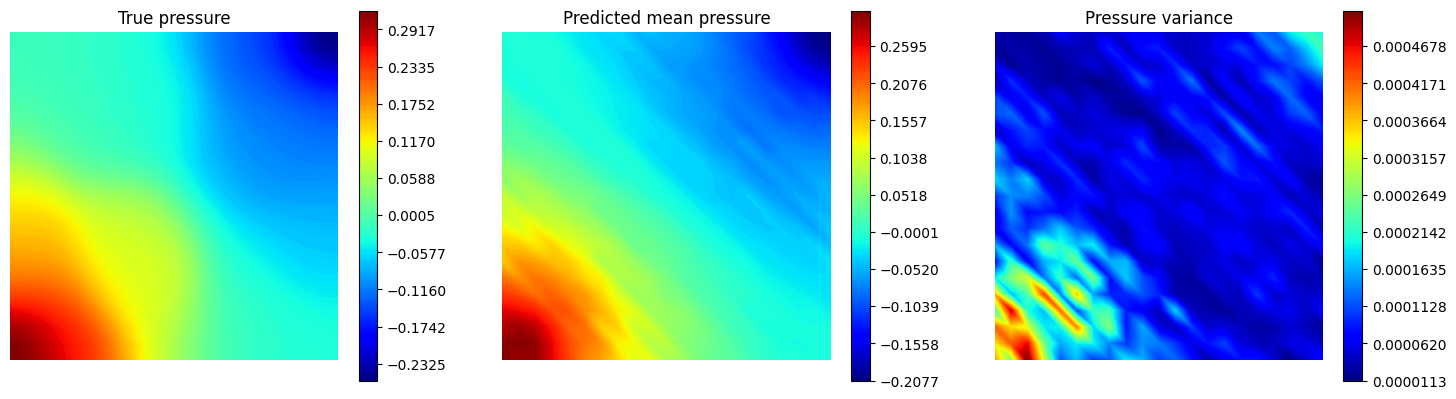

In [57]:
idx = 50

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(p_test[idx], V, cmap='jet', colorbar=True)
plt.title("True pressure")

plt.subplot(1, 3, 2)
fe.plot(p_pred_bayes_mean[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted mean pressure")

plt.subplot(1, 3, 3)
fe.plot(p_pred_bayes_var[idx], V, cmap='jet', colorbar=True)
plt.title("Pressure variance")

plt.show()

In [30]:
# Bayesian network for velocity

layer_1 = Local(V, V, support=0.25)
layer_2 = Local(V, V, support=0.25)
layer_3 = Local(V, V, support=0.25, activation=None)

v_model = DFNN(layer_1, layer_2, layer_3)

v_bayes = Bayesian(v_model)
v_bayes.He() # set prior on weights

In [31]:
v_svgd = SVGD(v_bayes, lr=1e-2)

In [32]:
v_svgd.train(K_train, u_x_train, ntrain=int(0.8*N_train), loss=mse(euclidean), epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 200/200, train: 0.937691, test: 0.952046: 100%|██████████| 200/200 [06:29<00:00,  1.95s/it]


In [33]:
u_x_pred_bayes_mean_train, u_x_pred_bayes_var_train = v_bayes.predict(K_train)
u_x_pred_bayes_mean, u_x_pred_bayes_var = v_bayes.predict(K_test)

In [34]:
# Compute relative error

error_train = torch.norm(u_x_train - u_x_pred_bayes_mean_train, dim=1) / torch.norm(u_x_train, dim=1)
error_test = torch.norm(u_x_test - u_x_pred_bayes_mean, dim=1) / torch.norm(u_x_test, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative training error: 23.37%
Relative test error: 23.78%


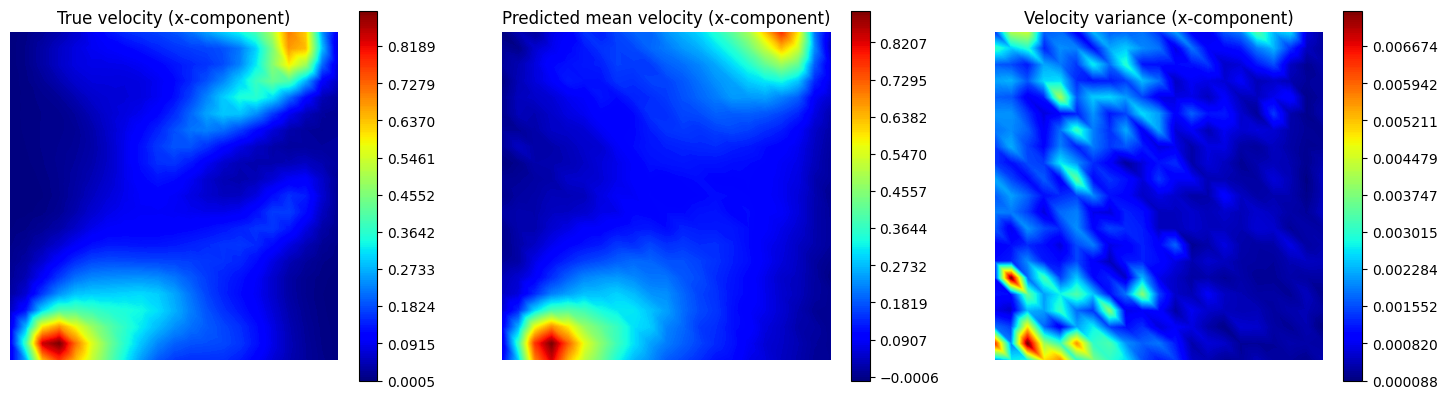

In [35]:
idx = 90

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(u_x_test[idx], V, cmap='jet', colorbar=True)
plt.title("True velocity (x-component)")

plt.subplot(1, 3, 2)
fe.plot(u_x_pred_bayes_mean[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted mean velocity (x-component)")

plt.subplot(1, 3, 3)
fe.plot(u_x_pred_bayes_var[idx], V, cmap='jet', colorbar=True)
plt.title("Velocity variance (x-component)")

plt.show()

In [67]:
V = fe.space(mesh, 'CG', 1) # 441 dofs
Nh = V.dim()

m = 16

# Encoder
# window, channels = (1,1), stride = 1, padding = 0
psi = Reshape(1, 21, 21) + \
      Conv2D(3, (1, m), stride=2, padding=1) + \
      Conv2D(3, (m, 2 * m), stride=2, padding=1) + \
      Conv2D(3, (2 * m, 4 * m), stride=2, padding=1)

# Decoder
psi_prime = Deconv2D(3, (4 * m, 2 * m), stride=2, padding=1) + \
            Deconv2D(3, (2 * m, m), stride=2) + \
            Deconv2D(3, (m, 1), stride=2, padding=1, activation=None) + \
            Reshape(-1)

v_model = DFNN(psi, psi_prime)

v_bayes = Bayesian(p_model)
v_bayes.He() # set prior on weights

In [68]:
v_svgd = SVGD(v_bayes, lr=1e-2)

In [69]:
v_svgd.train(K_train, u_x_train, ntrain=int(0.8*N_train), loss=mse(euclidean), epochs=200)

Epoch: 200/200, train: 0.240728, test: 0.333004: 100%|██████████| 200/200 [12:13<00:00,  3.67s/it]


In [70]:
u_x_pred_bayes_mean_train, u_x_pred_bayes_var_train = v_bayes.predict(K_train)
u_x_pred_bayes_mean, u_x_pred_bayes_var = v_bayes.predict(K_test)

In [71]:
# Compute relative error

error_train = torch.norm(u_x_train - u_x_pred_bayes_mean_train, dim=1) / torch.norm(u_x_train, dim=1)
error_test = torch.norm(u_x_test - u_x_pred_bayes_mean, dim=1) / torch.norm(u_x_test, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative training error: 12.20%
Relative test error: 13.75%


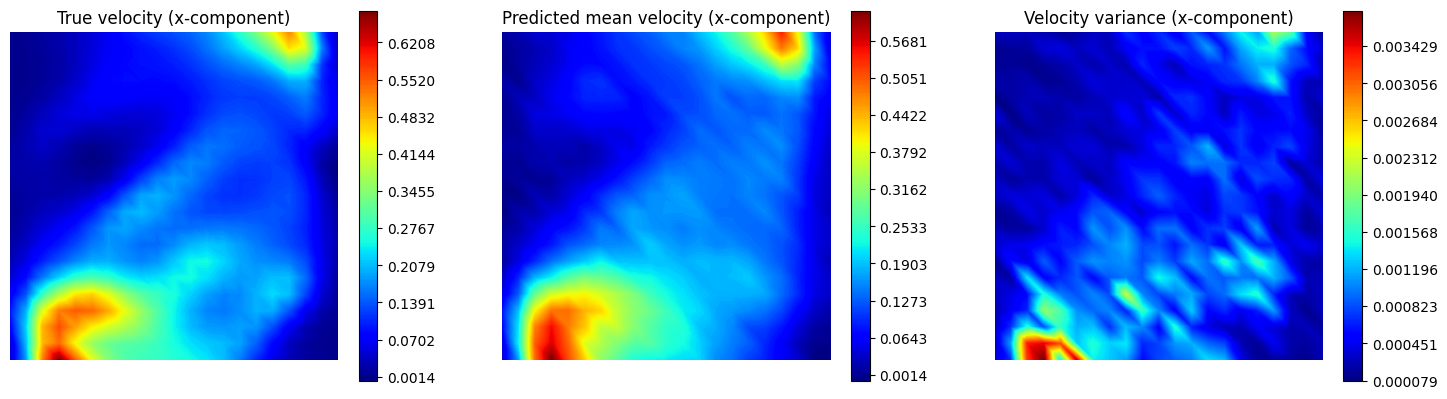

In [72]:
idx = 90

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
fe.plot(u_x_test[idx], V, cmap='jet', colorbar=True)
plt.title("True velocity (x-component)")

plt.subplot(1, 3, 2)
fe.plot(u_x_pred_bayes_mean[idx], V, cmap='jet', colorbar=True)
plt.title("Predicted mean velocity (x-component)")

plt.subplot(1, 3, 3)
fe.plot(u_x_pred_bayes_var[idx], V, cmap='jet', colorbar=True)
plt.title("Velocity variance (x-component)")

plt.show()

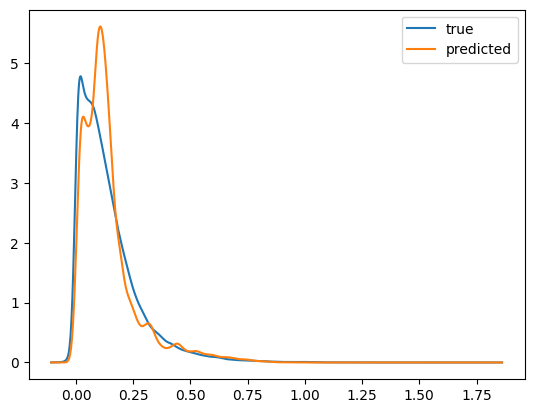

In [126]:
from scipy import stats

u_x_test_np = u_x_test.cpu().numpy().flatten()
u_x_pred_bayes_mean_np = u_x_pred_bayes_mean.cpu().numpy().flatten()

# Create a KDE estimate
kde_u_x_test = stats.gaussian_kde(u_x_test_np)
kde_u_x_pred_bayes_mean = stats.gaussian_kde(u_x_pred_bayes_mean_np)

x = np.linspace(u_x_test_np.min(), u_x_test_np.max(), 1000)
plt.plot(x, kde_u_x_test(x), label='true')
plt.plot(x, kde_u_x_pred_bayes_mean(x), label='predicted')
plt.legend()
plt.show()

Reliability Diagram:

1. Compute the p% predictive interval for each test data point based on the Gaussian quantiles using the predictive mean and variance;
2. Compute the frequency of the test targets that fall within this predictive interval.

For a well-calibrated regression model, the observed frequency should be close to p%. The reliability diagram is the plot of the observed frequency with respect to p.

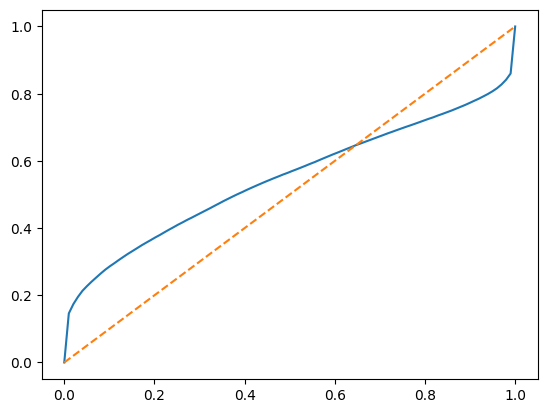

In [127]:
from scipy.stats import norm

u_x_test_np = u_x_test.cpu().numpy().flatten()
u_x_pred_bayes_mean_np = u_x_pred_bayes_mean.cpu().numpy().flatten()
u_x_pred_bayes_var_np = u_x_pred_bayes_var.cpu().numpy().flatten()

quantiles = np.linspace(0, 1, 100)

calibration_curve = np.zeros_like(quantiles)

for i in range(len(u_x_test_np)):
	normal_quantiles = norm.ppf(quantiles, loc=u_x_pred_bayes_mean_np[i], scale=np.sqrt(u_x_pred_bayes_var_np[i]))
	mask = (normal_quantiles > u_x_test_np[i])
	calibration_curve += mask
	
calibration_curve /= len(u_x_test_np)

plt.plot(quantiles, calibration_curve)
plt.plot(quantiles, quantiles, '--')
plt.show()

- Tradeoff memory vs execution time (is mesh-informed prior "sparse enough" to enable vectorized implementation? which are the limits?)
- torch.jit to make basic operation (e.g. matmul) faster
- Verbose, ETA, etc. (like in ROM)
- Choice of prior?